### Библиотеки 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from crnn_prep_dataset import save_datasets
import random

### Создание и сохраение датасета с предобработкой изображений

In [2]:
DATA_DIR = './data'

# Создание и сохранение датасетов
train_ds, test_ds = save_datasets(DATA_DIR)



Датасеты сохранены в ./data


In [3]:
# 4. Функция для визуализации случайных изображений
def visualize_random_samples(dataset, num_samples=25, figsize=(15, 15)):
    # Случайные индексы
    indices = random.sample(range(len(dataset)), num_samples)
    
    # Создание сетки 5x5
    plt.figure(figsize=figsize)
    for i, idx in enumerate(indices):
        image, label = dataset[idx]
        
        # Удаление размерности канала и конвертация в numpy
        img_display = image.squeeze(0).numpy()
        
        # Отображение
        plt.subplot(5, 5, i+1)
        plt.imshow(img_display, cmap='gray')
        plt.title(label, fontsize=8)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


Примеры обработанных изображений:


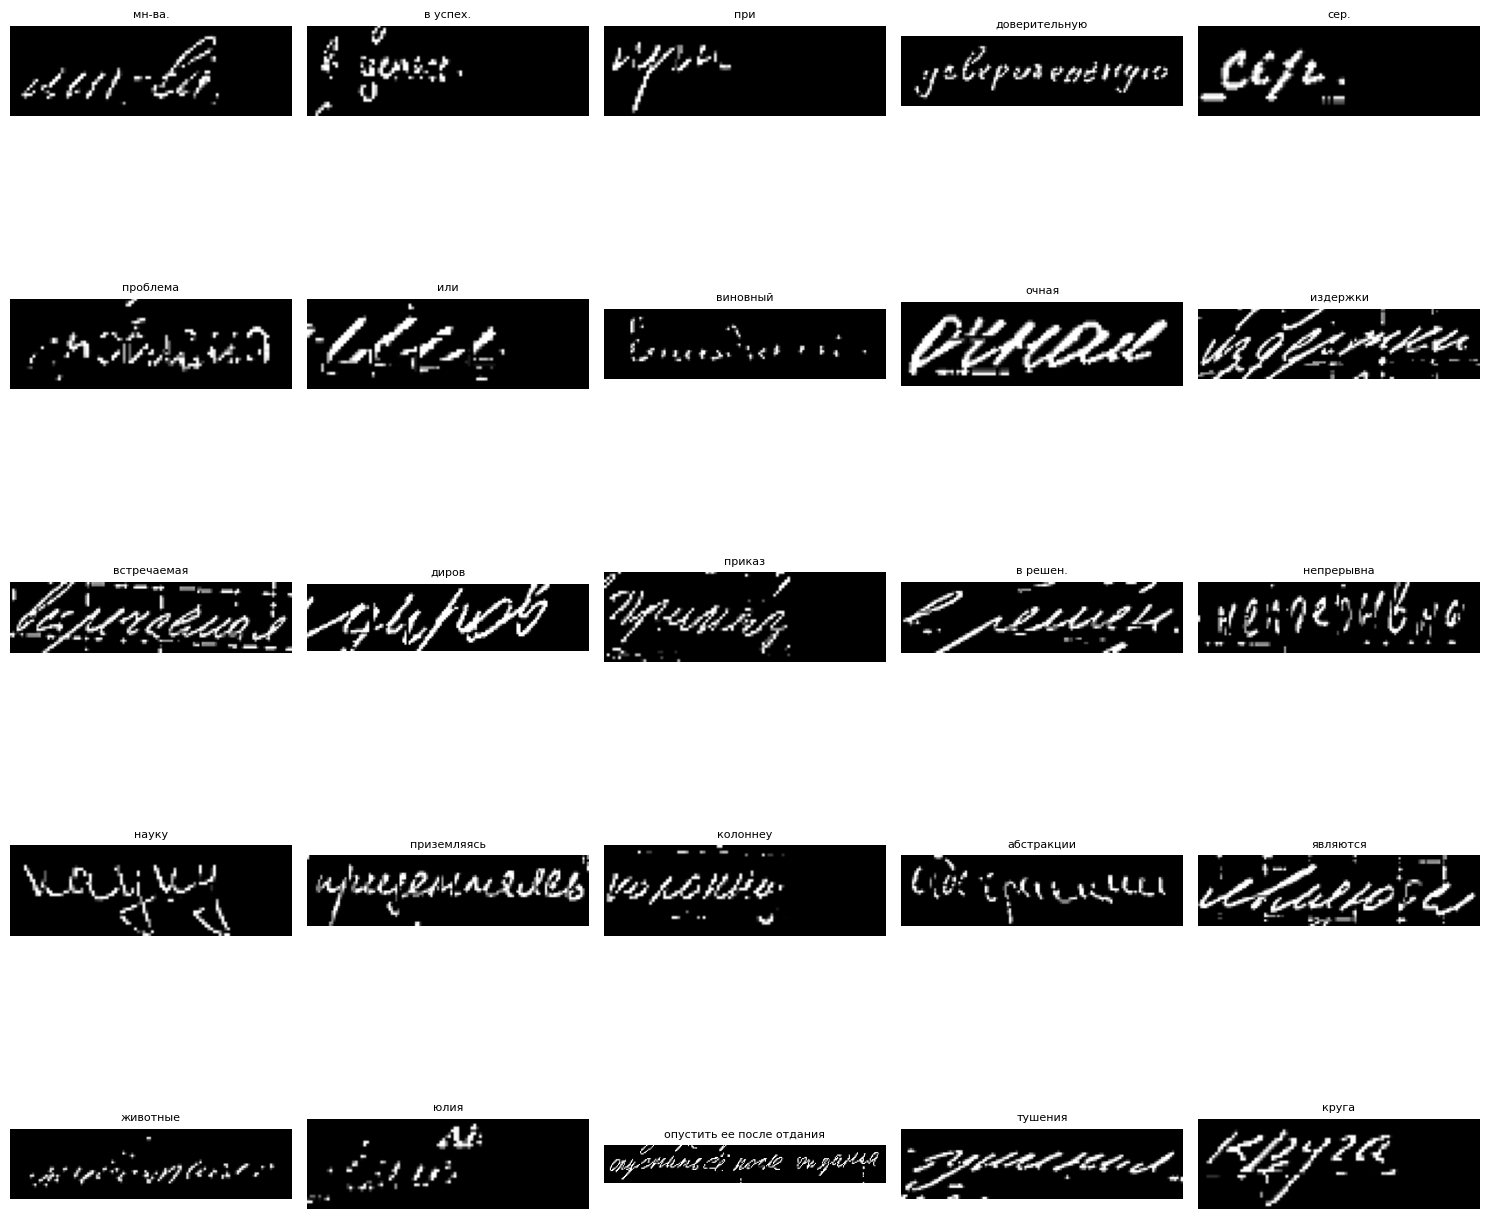

In [4]:
# Визуализация 25 случайных изображений из тренировочного набора
print("\nПримеры обработанных изображений:")
visualize_random_samples(train_ds)

### CRNN

In [5]:
# import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import Dataset, DataLoader
# from torch.nn import CTCLoss
# import torch.nn.functional as F
# import numpy as np
# import os

# class Config:
#     alphabet = ' абвгдеёжзийклмнопрстуфхцчшщъыьэюя0123456789!@#$%^&*()_+-=[]{};:",.<>/?'
#     num_classes = len(alphabet) + 1  # +1 для blank символа
#     input_height = 32
#     lstm_hidden = 256
#     lstm_num_layers = 2
#     batch_size = 16
#     lr = 0.001
#     epochs = 20
#     device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# class CTCLabelConverter:
#     def __init__(self, alphabet):
#         self.alphabet = alphabet
#         self.char2idx = {char: idx for idx, char in enumerate(alphabet)}
#         self.idx2char = {idx: char for idx, char in enumerate(alphabet)}
#         self.blank = len(alphabet)
    
#     def encode(self, text_batch):
#         """Кодирование текста в индексы для CTC"""
#         targets = []
#         target_lengths = []
        
#         for text in text_batch:
#             target = [self.char2idx.get(char, self.char2idx[' ']) for char in text]
#             targets.extend(target)
#             target_lengths.append(len(text))
        
#         return (torch.tensor(targets, dtype=torch.long),
#                 torch.tensor(target_lengths, dtype=torch.long))
    
#     def decode(self, preds, pred_lengths):
#         """Декодирование предсказаний в текст"""
#         texts = []
#         start_idx = 0
#         for length in pred_lengths:
#             pred = preds[start_idx:start_idx+length]
#             text = []
#             for j in range(length):
#                 idx = pred[j]
#                 if idx != self.blank and (j == 0 or idx != pred[j-1]):
#                     if idx < len(self.alphabet):
#                         text.append(self.idx2char[idx])
#             texts.append(''.join(text))
#             start_idx += length
#         return texts

# def collate_fn(batch):
#     """Обработка батча с изображениями разной ширины"""
#     images, labels = zip(*batch)
    
#     # Находим максимальную ширину в батче
#     max_width = max(img.shape[2] for img in images)
    
#     # Дополняем изображения до максимальной ширины
#     padded_images = []
#     for img in images:
#         pad_amount = max_width - img.shape[2]
#         if pad_amount > 0:
#             img = F.pad(img, (0, pad_amount, 0, 0))
#         padded_images.append(img)
    
#     return torch.stack(padded_images), labels

# class CRNN(nn.Module):
#     def __init__(self, config):
#         super(CRNN, self).__init__()
#         self.config = config
        
#         # CNN часть
#         self.cnn = nn.Sequential(
#             nn.Conv2d(1, 64, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(64, 128, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
#             nn.Conv2d(128, 256, 3, stride=1, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
#             nn.Conv2d(256, 256, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
#             nn.Conv2d(256, 512, 3, stride=1, padding=1), nn.BatchNorm2d(512), nn.ReLU(),
#             nn.Conv2d(512, 512, 3, stride=1, padding=1), nn.ReLU(), nn.MaxPool2d((2, 1), (2, 1)),
#             nn.Conv2d(512, 512, 2, stride=1, padding=0), nn.BatchNorm2d(512), nn.ReLU()
#         )
        
#         # RNN часть
#         self.rnn = nn.LSTM(
#             input_size=512,
#             hidden_size=config.lstm_hidden,
#             num_layers=config.lstm_num_layers,
#             bidirectional=True,
#             batch_first=True
#         )
        
#         # Полносвязный слой
#         self.fc = nn.Linear(config.lstm_hidden * 2, config.num_classes)
    
#     def forward(self, x):
#         # CNN
#         x = self.cnn(x)
        
#         # Подготовка для RNN
#         b, c, h, w = x.size()
#         x = x.squeeze(2).permute(0, 2, 1)
        
#         # RNN
#         x, _ = self.rnn(x)
        
#         # Классификация
#         x = self.fc(x)
#         return x.log_softmax(2)

# def train_epoch(model, loader, criterion, optimizer, converter, config):
#     model.train()
#     total_loss, total_correct, total_samples = 0, 0, 0
    
#     for images, labels in loader:
#         images = images.to(config.device)
#         batch_size = images.size(0)
        
#         # Подготовка меток
#         targets, target_lengths = converter.encode(labels)
#         targets = targets.to(config.device)
#         target_lengths = target_lengths.to(config.device)
        
#         # Forward pass
#         optimizer.zero_grad()
#         outputs = model(images)
        
#         # Проверка размерностей
#         if outputs.size(1) == 0:
#             continue  # Пропускаем батчи с нулевой длиной последовательности
            
#         # Подготовка input_lengths
#         input_lengths = torch.full(
#             size=(batch_size,),
#             fill_value=outputs.size(1),
#             dtype=torch.long,
#             device=config.device
#         )
        
#         # Убедимся, что все размерности правильные
#         assert len(input_lengths) == batch_size, "input_lengths must be of size batch_size"
#         assert len(target_lengths) == batch_size, "target_lengths must be of size batch_size"
        
#         # CTC Loss
#         loss = criterion(outputs.permute(1, 0, 2),  # (T, N, C)
#                         targets, 
#                         input_lengths, 
#                         target_lengths)
        
#         # Backward pass
#         loss.backward()
#         optimizer.step()
        
#         # Вычисление точности
#         _, preds = outputs.max(2)
#         decoded_texts = converter.decode(
#             preds.permute(1, 0).contiguous().view(-1).cpu(),
#             target_lengths.cpu()
#         )
        
#         # Сравнение с оригинальными метками
#         for pred, true in zip(decoded_texts, labels):
#             if pred == true.lower():
#                 total_correct += 1
#         total_samples += batch_size
        
#         total_loss += loss.item() * batch_size
    
#     return total_loss / total_samples if total_samples > 0 else float('inf'), total_correct / total_samples if total_samples > 0 else 0

# def test_model(model, loader, criterion, converter, config):
#     model.eval()
#     total_loss, total_correct, total_samples = 0, 0, 0
    
#     with torch.no_grad():
#         for images, labels in loader:
#             images = images.to(config.device)
#             batch_size = images.size(0)
            
#             # Подготовка меток
#             targets, target_lengths = converter.encode(labels)
#             targets = targets.to(config.device)
#             target_lengths = target_lengths.to(config.device)
            
#             # Forward pass
#             outputs = model(images)
            
#             # Пропускаем батчи с нулевой длиной последовательности
#             if outputs.size(1) == 0:
#                 continue
                
#             # Подготовка input_lengths
#             input_lengths = torch.full(
#                 size=(batch_size,),
#                 fill_value=outputs.size(1),
#                 dtype=torch.long,
#                 device=config.device
#             )
            
#             # CTC Loss
#             loss = criterion(outputs.permute(1, 0, 2),  # (T, N, C)
#                             targets, 
#                             input_lengths, 
#                             target_lengths)
            
#             # Вычисление точности
#             _, preds = outputs.max(2)
#             decoded_texts = converter.decode(
#                 preds.permute(1, 0).contiguous().view(-1).cpu(),
#                 target_lengths.cpu()
#             )
            
#             # Сравнение с оригинальными метками
#             for pred, true in zip(decoded_texts, labels):
#                 if pred == true.lower():
#                     total_correct += 1
#             total_samples += batch_size
            
#             total_loss += loss.item() * batch_size
    
#     return total_loss / total_samples if total_samples > 0 else float('inf'), total_correct / total_samples if total_samples > 0 else 0

# def main(data_dir='data'):
#     config = Config()
    
#     # Загрузка датасетов
#     print("Загрузка датасетов...")
#     train_dataset = train_ds #torch.load(os.path.join(data_dir, 'train_dataset.pt'))
#     test_dataset = test_ds#torch.load(os.path.join(data_dir, 'test_dataset.pt'))
    
#     # Создание DataLoader
#     train_loader = DataLoader(
#         train_dataset,
#         batch_size=config.batch_size,
#         shuffle=True,
#         collate_fn=collate_fn,
#         num_workers=0
#     )
#     test_loader = DataLoader(
#         test_dataset,
#         batch_size=config.batch_size,
#         shuffle=False,
#         collate_fn=collate_fn,
#         num_workers=0
#     )
    
#     # Инициализация модели
#     print("Инициализация модели...")
#     model = CRNN(config).to(config.device)
    
#     # Конвертер для меток
#     converter = CTCLabelConverter(config.alphabet)
    
#     # Функция потерь и оптимизатор
#     criterion = CTCLoss()
#     optimizer = optim.Adam(model.parameters(), lr=config.lr)
    
#     # Обучение
#     print("Начало обучения...")
#     for epoch in range(config.epochs):
#         train_loss, train_acc = train_epoch(
#             model, train_loader, criterion, optimizer, converter, config
#         )
#         test_loss, test_acc = test_model(
#             model, test_loader, criterion, converter, config
#         )
        
#         print(f"Epoch {epoch+1}/{config.epochs}")
#         print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc:.4f}")
#         print(f"Test Loss: {test_loss:.4f} | Acc: {test_acc:.4f}")
#         print("-" * 50)
    
#     # Сохранение модели
#     torch.save(model.state_dict(), 'crnn_model.pth')
#     print("Модель сохранена в crnn_model.pth")

# if __name__ == "__main__":
#     main()